# Robinhood data

The data from Robintrack is used as a proxy for Robinhood trader behaviour. It contains quite a lot of information which is not relevant for this research. As I am only looking at daily data, most hourly data points within this dataset are not used. Hence we will be filtered and adjust some of this data with the code in this file.


The Robintrack data set contains data points outside trade times.
This can be the case either
- during the weekend, or
- during the weekday outside trading hours
  Trading hours are weekdays from (Robinhood, 2022a):
  - 09:30 to 16:00 Eastern Daylight Time (ET)
  - 15:30 to 22:00 Central European Time (CET)
  - 13:30 to 20:00 Coordinated Universal Time (UTC)

The Robintrack data set is based on UTC times. I will be taking the last `users_holding` value of each day, to the closing day value.

In [33]:
import os
import numpy as np
import pandas as pd
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 20)

In [3]:
def loop_tickers(func):
    '''Decorator that loops all (ticker) files in the directory.'''
  
    def wrap(*args, **kwargs):
        if 'file_dir' in kwargs:
            for filename in os.listdir(filedir):
                csv_path = os.path.join(filedir, filename)
                kwargs['ticker'] = csv_path.split("\\")[-1].split(".")[0]
                # checking if it is a file
                if os.path.isfile(csv_path):
                    
                    message = f"""Now executing function {func.__name__} for [{filename}], variables:
                    - csv_path: [{csv_path}]
                    - kwargs: [{kwargs}])"""
                    print(message)

                    result = func(csv_path=csv_path, *args, **kwargs)
                    
        else:
            raise ValueError("Wrapper can not loop, as no file directory given. Please specify which folder needs to be looped by setting 'file_dir' variable.") 
        
        
        
        return result
    return wrap

In [5]:
x = False
def filters(df):
    #     -----------------     Filtering data and convert to daily     -----------------
    # Create dataframe and make sure timestamp is read as datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Create more info surrounding the date and time
    df['date'] = df['timestamp'].dt.date
    df['dayname'] = df['timestamp'].dt.day_name()

    # Remove all observations which are not weekdays
    df = df[~((df['dayname'] == "Saturday") | (df['dayname'] == "Sunday"))]
    
    # Keep only the last value of each day. This will portray the closing value of the users_holding variable for each day
    df = df.sort_values('timestamp').groupby('date').tail(1)

    #     -----------------     Creating new data     -----------------
    # Create column with numerical user difference
    df['change'] = df['users_holding'].diff()
    
    # Create column with percentual user difference
    df['pct_change'] = df['users_holding'].pct_change().round(4)
    
    # Dropping na values (this should only be the first column)
    df = df.dropna()
    
    return df

In [ ]:
@loop_tickers
def filter_data(csv_path, *args, **kwargs):
    """This function filters the unfiltered data to daily data"""
    df = pd.read_csv(csv_path)
    
    df = filters(df)

    # Setup save location by changing base_path from /unfiltered to /filtered
    base_path = os.path.dirname(kwargs['file_dir'])
    base_path = os.path.join(base_path, 'daily_data').replace('\\', '/')
    
    ticker = kwargs['ticker']
    save_path = os.path.join(base_path, f"{ticker}.csv").replace('\\', '/')

    # Save results
    df.to_csv(save_path, encoding='utf-8')


filedir = r"E:/Users/Christiaan/Large_Files/Thesis/robintrack/popularity_export"
filter_data(file_dir= filedir)



In [ ]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\robintrack\popularity_export\AAPL.csv"
df = pd.read_csv(csv_path)
df = filters(df)
df

## ToDo


In [7]:
"""
# Check how % ownership of firm changes compared to RH platform

# Add and smooth for missing days (it seens Robintrack had outages)
- 8-10 aug 2018
- 23-30 january 2019
- 6-16 january 2020

# Smoothing of interpolation?

# Make final prediction method
                                        Prediction 1: 
stock_holdings t1 = stock_holdings t0 + (% user bezit * verandering totaal stock ownership RH)
                                        Prediction 2: 
stock_holdings t1 = stock_holdings t0 + (% user bezit * (verandering totaal stock ownership RH / avg_stocks_user))


# ... Reddit
"""


In [5]:
path = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_data' # use your path

all_files = glob.glob(os.path.join(path, "*.csv"))
all_files = [item.replace('\\', '/') for item in all_files]
all_files
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')


In [6]:
testdf = df
testdf

,Unnamed: 0.1,Unnamed: 0,timestamp,users_holding,date,dayname,change,pct_change,ticker
0,0,20,2018-05-03 23:45:58,587.0,2018-05-03,Thursday,-3.0,-0.0051,A
1,1,44,2018-05-04 23:46:00,588.0,2018-05-04,Friday,1.0,0.0017,A
2,2,112,2018-05-07 23:45:59,576.0,2018-05-07,Monday,-12.0,-0.0204,A
3,3,136,2018-05-08 23:46:04,580.0,2018-05-08,Tuesday,4.0,0.0069,A
4,4,160,2018-05-09 23:45:58,582.0,2018-05-09,Wednesday,2.0,0.0034,A
...,...,...,...,...,...,...,...,...,...
4089713,578,19567,2020-08-07 23:47:53,23.0,2020-08-07,Friday,0.0,0.0000,_PRN
4089714,579,19639,2020-08-10 23:47:38,24.0,2020-08-10,Monday,1.0,0.0435,_PRN
4089715,580,19663,2020-08-11 23:47:57,24.0,2020-08-11,Tuesday,0.0,0.0000,_PRN
4089716,581,19682,2020-08-12 23:48:20,24.0,2020-08-12,Wednesday,0.0,0.0000,_PRN


## Robinhood platform wide data

In order to gain insights into the Robinhood paltform as a whole, the data of all stocks is combined into 1 dataframe. To begin, the tickers are added to each file so the data can be traced to the right stock in the combined csv file.

In [ ]:
filedir = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_data'

# This loop adds the ticker name to the csv files
for filename in os.listdir(filedir):
    csv_path = os.path.join(filedir, filename)
    ticker = filename.split(".")[0]
    
    df = pd.read_csv(csv_path)
    
    df['ticker'] = ticker
    
    df.to_csv(csv_path, encoding='utf-8')

The csv files (with the now newly added tickers) are now combined.

In [47]:
path = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_data' # use your path

# Create a list in which all file paths are collected
all_files = glob.glob(os.path.join(path, "*.csv"))
all_files = [item.replace('\\', '/') for item in all_files]

# Create the dataframe in which all of these different files are added into one dataframe.
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Change the 'date' column into a datetime object
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

# Remove any potential unnamed collumns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Saving the df
save = False
if save:
    df.to_csv(r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\all_stocks_daily.csv', encoding='utf-8')

df

,Unnamed: 0.1,Unnamed: 0,timestamp,users_holding,date,dayname,change,pct_change,ticker
0,0,20,2018-05-03 23:45:58,587.0,2018-05-03,Thursday,-3.0,-0.0051,A
1,1,44,2018-05-04 23:46:00,588.0,2018-05-04,Friday,1.0,0.0017,A
2,2,112,2018-05-07 23:45:59,576.0,2018-05-07,Monday,-12.0,-0.0204,A
3,3,136,2018-05-08 23:46:04,580.0,2018-05-08,Tuesday,4.0,0.0069,A
4,4,160,2018-05-09 23:45:58,582.0,2018-05-09,Wednesday,2.0,0.0034,A
...,...,...,...,...,...,...,...,...,...
4089713,578,19567,2020-08-07 23:47:53,23.0,2020-08-07,Friday,0.0,0.0000,_PRN
4089714,579,19639,2020-08-10 23:47:38,24.0,2020-08-10,Monday,1.0,0.0435,_PRN
4089715,580,19663,2020-08-11 23:47:57,24.0,2020-08-11,Tuesday,0.0,0.0000,_PRN
4089716,581,19682,2020-08-12 23:48:20,24.0,2020-08-12,Wednesday,0.0,0.0000,_PRN


This data can be used to create a `total_users` dataframe in which the total amount of stock holdings can be seen for the entire Robinhood platform. This figure mean that if RH has 1,000,000 users and they all own 3 different stocks, then the `total_users` would find 3,000,000 stocks. This is regardless if these users have 1 or 100 of these 3 different stocks.

In [91]:
# Create the data in which the total amount of user holdings are calculated.
total_users = df[['date', 'users_holding']].groupby('date', as_index=False).sum()

## Data exploration and graphs

**Stock availability**

In the graph below, the number of stocks available on the Robinhood platform are plotted.

In [17]:
# Read files which contains all info on all stocks.
csv_path = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\all_stocks_daily.csv'
df = pd.read_csv(csv_path)

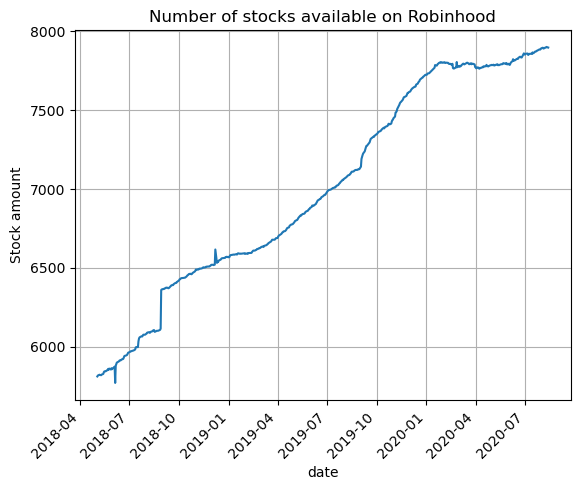

In [14]:
# Create the data in which the total stock offerings by Robinhood are calculated.
stock_choice = testdf.groupby('date', as_index=False).size()

# Plot the graph
fig, ax = plt.subplots()
ax.plot(stock_choice['date'], stock_choice['size'])

ax.set(xlabel='date', ylabel='Stock amount',
       title='Number of stocks available on Robinhood')
ax.grid()

plt.xticks(rotation=45, ha='right')
plt.show()

**Total stock positions Robinhood**

To get an idea of the activity on the Robinhood platform, I take a look at the amounnt of stock positions held by Robinhood users. In the graph below, the number of stocks held by Robinhood investors are plotted based on the `total_users` dataframe created earlier.

<a class="anchor" id="graph1"></a>

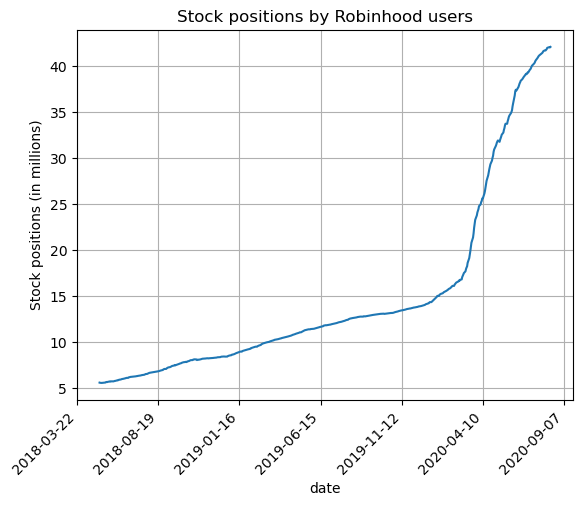

In [62]:
# Plot the graph
fig, ax = plt.subplots()
ax.plot(total_users['date'], total_users['users_holding']/1000000)

ax.set(xlabel='date', ylabel='Stock positions (in millions)',
       title='Stock positions by Robinhood users')
ax.grid()

stepsize = 150
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize))

plt.xticks(rotation=45, ha='right')
plt.show()

### Total unique stock positions vs total users on Robinhood

In the previous graph the number of stocks held by Robinhood investors was plotted. The problem with this graph, is that the amount of stock positions is not per se telling of the amount of users of the Robinhood platform. 

Although the graph above could indicate an increase in users, it could also just be that the existing users started to diversify and own a wider selection of stocks. Please do remember that the amount of a single stock a user owns is still irrelevant.

To tackle this problem, the total amount of users are needed. With this, we can calculate the average number of different stocks per user.

*Robinhood users*

To estimate the amount of Robinhood users, I make use of their SEC filings to extract `Monthly Active Users (MAU)` and `Net Cumulative Funded Accounts`. 

I will be mainly focussing on the Net Cumulative Funded Accounts, as these account contain a balance with which trades can be made. Robinhoods definition of Net Cumulative Funded Accounts is: "*Net Cumulative Funded Accounts. We define Net Cumulative Funded Accounts as the total of Net Funded Accounts from inception to a stated date or period end. “Net Funded Accounts” is the total number of Funded Accounts for a stated period, excluding “churned users” and including “resurrected users” as of the end of that period. A “Funded Account” is a Robinhood account into which the account user makes an initial deposit or money transfer, of any amount, during the relevant period, 25 which account is designed to provide a customer with access to any and all of the products offered on our platform. Users are considered “churned” if their accounts were previously Funded Accounts and their account balance (which is measured as the fair value of assets in the user’s account less the amount due from the user) drops to or below zero dollars (which negative balances typically result from Fraudulent Deposit Transactions and, less often, from margin loans) for 45 consecutive calendar days. Users are considered “resurrected” if they were considered churned users during and as of the end of the immediately preceding period, and had their account balance increase above zero (and are not considered churned users) in the current period. For more information about Fraudulent Deposit Transactions, see “Management’s Discussion and Analysis of Financial Condition and Results of Operations—Key Components of our Results of Operations—Operating Expenses—Operations.*"

The [picture](https://www.sec.gov/Archives/edgar/data/1783879/000162828021013318/robinhoods-1.htm) below shows Robinhood's `Net Cumulative Funded Accounts` growth over the years.

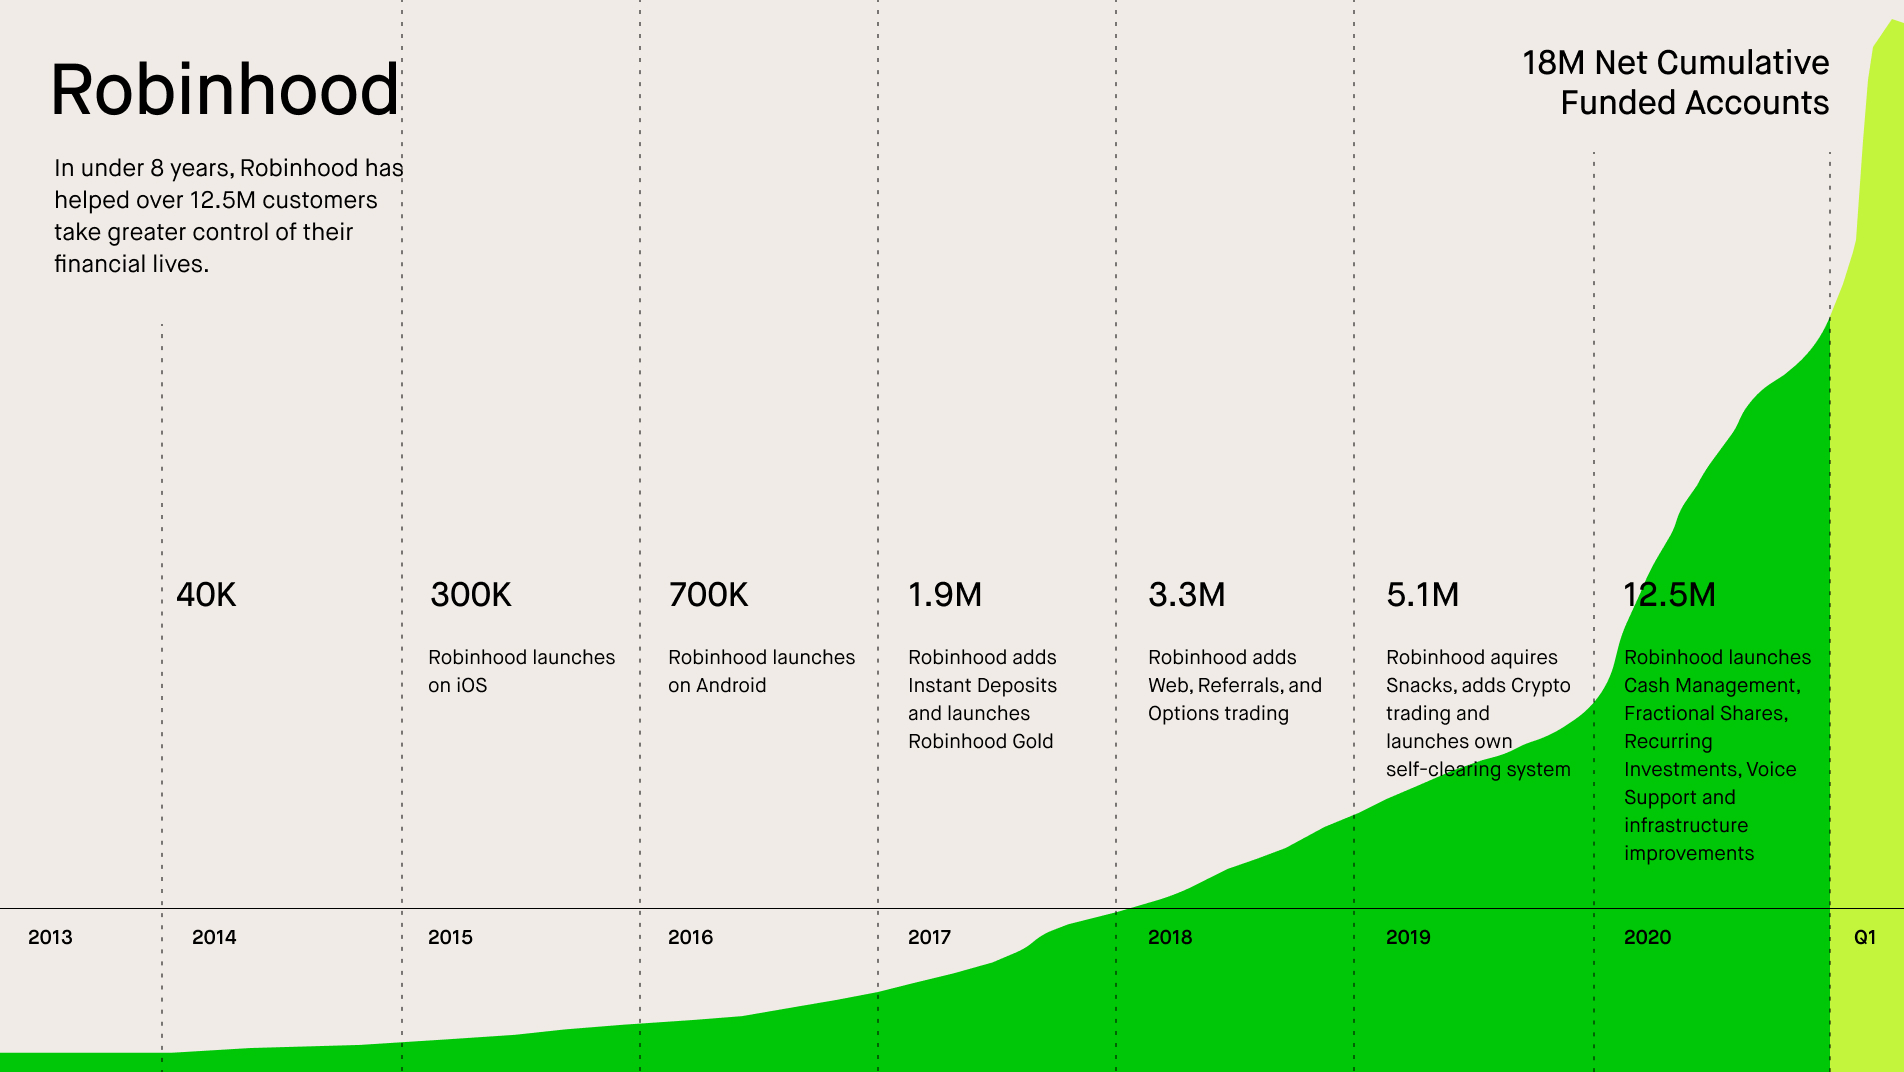

I have tried to recreate this graph using the data from the Robinhood SEC filings (using Form S-1, quarterly and annual reports). The values in red are values which are missing and have been interpolated. Based

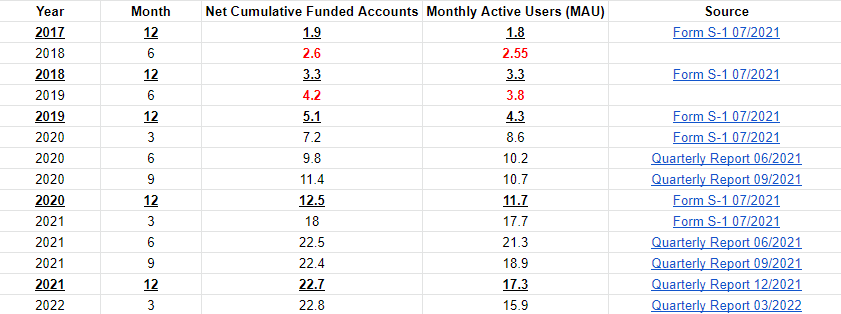

**User estimation**

To estimate the Robinhood users I will be using the pandas interpolation function. Please see the code below

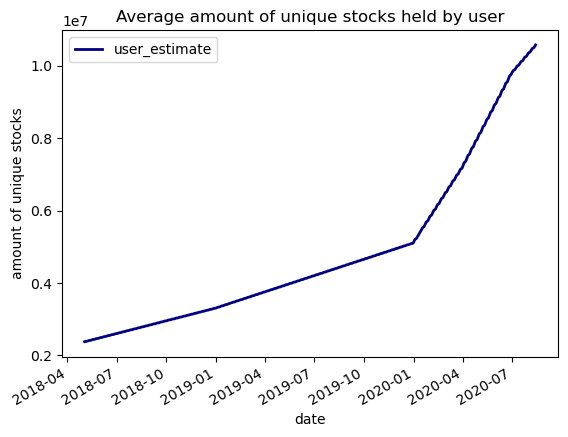

In [226]:
# Create an empty dataframe
user_prediction_df = pd.DataFrame()

# Create a date range relevant for interpolation.
user_prediction_df = user_prediction_df.reindex(pd.date_range("2018-01-01", "2020-9-30"), fill_value="NaN")

# Create and fill user_estimate column with nans
user_prediction_df['user_estimate'] = np.nan

# Put in values found from Robinhood filings (see above)
user_prediction_df.loc['2018-01-01'] = 1900000
user_prediction_df.loc['2018-06-30'] = 2600000
user_prediction_df.loc['2018-12-31'] = 3300000
user_prediction_df.loc['2019-06-30'] = 4200000
user_prediction_df.loc['2019-12-31'] = 5100000
user_prediction_df.loc['2020-03-31'] = 7200000
user_prediction_df.loc['2020-06-30'] = 9800000
user_prediction_df.loc['2020-09-30'] = 11400000

# Delete weekends from timeframe 
""" !!!
This is done to not get a user bump on monday, but rather smooth user out over the week!
Although this assumes no new users join on the weekend, I believe this to be the best (neutral) approach as no further 
information is available on when Robinhood's peak hours are in terms of attracting new customers.
""" 
user_prediction_df = user_prediction_df[user_prediction_df.index.dayofweek < 5]

# Use pandas linear interpolation to fill in missing values
user_prediction_df = user_prediction_df['user_estimate'].interpolate(method='linear').round(0)

# Convert the index to a column 
user_prediction_df = user_prediction_df.reset_index(level=0)
user_prediction_df = user_prediction_df.rename(columns={"index": "date"})

# Plot results
ax = acc_holdings_df.plot(x="date", y=["user_estimate"], lw=2, colormap='jet', markersize=10, title='Average amount of unique stocks held by user')
ax.set(xlabel="date", ylabel="amount of unique stocks")
plt.show()

Now we have a user estimate for each period, I will merge this data with the `total_users` data to find out what the average different stock holdings per account are.

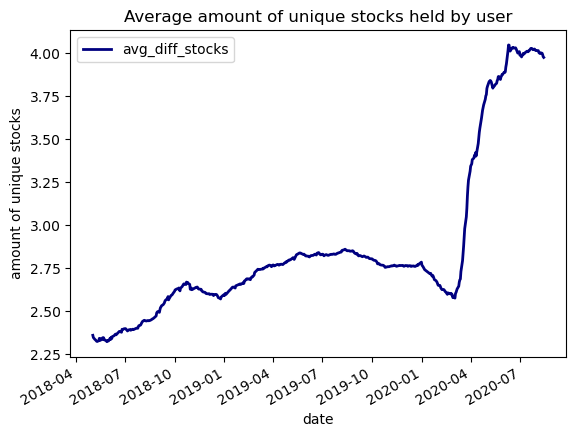

In [220]:
# Putting total_users in new dataframe to preserve original
acc_holdings_df = total_users

# Merge user prediction dataframe with total_users dataframe
acc_holdings_df = acc_holdings_df.merge(user_prediction_df, how='left', left_on='date', right_on='date')

# Calculate average different stocks per account
acc_holdings_df['avg_diff_stocks'] = acc_holdings_df['users_holding'] / acc_holdings_df['user_estimate']

# Plot results
ax = acc_holdings_df.plot(x="date", y=["avg_diff_stocks"], lw=2, colormap='jet', markersize=10, title='Average amount of unique stocks held by user')
ax.set(xlabel="date", ylabel="amount of unique stocks")
plt.show()


In [221]:
acc_holdings_df.to_csv(r"C:\Users\Christiaan\Downloads\acc_holdings_df.csv", encoding='utf-8')

**Findings on unique stock positions vs total users on Robinhood**

The graphs above show not only that the number of users on Robinhood has increased, but also the number of unique stocks held by these users.

This information is relevant when correcting for user growth in the stock data. As the `users_holding` figure only keeps track of the amount of people having any amount of the stock, the massive growth which could be seen in this [graph](#graph1) would cause the correction to be influenced by the amount of unique stocks held by investors.



In [29]:
ticker_list = ['TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AAPL', 'AMZN', 'SQ', 'BABA', 'V', 'NFLX', 'IQ', 'ATVI', 'SHOP', 'BA', 'NVDA', 'GE', 'WMT', 'SBUX', 'F', 'TLRY', 'LULU', 'BAC', 'GME']


In [92]:
relative_size_df = total_users
for ticker in ticker_list:
    # Get ticker information from combined dataframe
    ticker_df = df[df['ticker'] == ticker].reset_index()
    
    # Only keep 2 necessary columns
    ticker_df = ticker_df[['date', 'users_holding']]
    
    # Rename column users_holding to ticker name
    ticker_df.rename(columns={'users_holding': f'{ticker}'}, inplace=True)
    
    # Merge with total users holding data
    relative_size_df = relative_size_df.merge(ticker_df, how='outer', left_on='date', right_on='date')


In [93]:
relative_size_df

,date,users_holding,TSLA,MU,SNAP,AMD,DIS,MSFT,AAPL,AMZN,...,BA,NVDA,GE,WMT,SBUX,F,TLRY,LULU,BAC,GME
0,2018-05-03,5605203.0,83646.0,58217.0,76547.0,127847.0,60491.0,112934.0,143747.0,72788.0,...,18800.0,76137.0,134674.0,28374.0,40983.0,131246.0,NaN,2823.0,78886.0,5517.0
1,2018-05-04,5587108.0,83240.0,57684.0,76950.0,125902.0,60117.0,112007.0,141424.0,72090.0,...,18606.0,75477.0,134446.0,28245.0,40668.0,130621.0,NaN,2861.0,78732.0,5507.0
2,2018-05-07,5572033.0,81129.0,57384.0,77498.0,124479.0,60922.0,111135.0,141179.0,71212.0,...,18273.0,74583.0,134461.0,29361.0,41439.0,130891.0,NaN,2886.0,78571.0,5522.0
3,2018-05-08,5579299.0,80656.0,57182.0,78835.0,123551.0,62771.0,111525.0,140820.0,71574.0,...,18163.0,75016.0,134010.0,29613.0,41485.0,130966.0,NaN,2902.0,78294.0,5489.0
4,2018-05-09,5581690.0,79994.0,56786.0,79115.0,122632.0,63583.0,111227.0,140742.0,71254.0,...,17934.0,76174.0,134101.0,31348.0,41721.0,132191.0,NaN,2892.0,77927.0,5457.0
5,2018-05-10,5586070.0,79683.0,57412.0,79431.0,122279.0,62430.0,110941.0,140904.0,71368.0,...,17861.0,78820.0,134375.0,31868.0,41633.0,131573.0,NaN,2886.0,77793.0,5430.0
6,2018-05-11,5595100.0,80092.0,56826.0,79634.0,122007.0,62000.0,111044.0,140950.0,71523.0,...,17842.0,77926.0,135050.0,32162.0,41902.0,131686.0,NaN,2878.0,78042.0,5490.0
7,2018-05-14,5617733.0,81389.0,56948.0,79931.0,121203.0,61567.0,111149.0,141199.0,71760.0,...,17821.0,77504.0,135059.0,32455.0,41975.0,131765.0,NaN,2882.0,78507.0,5424.0
8,2018-05-15,5664090.0,84671.0,56695.0,80599.0,120583.0,61433.0,111560.0,141449.0,73392.0,...,17782.0,78604.0,135338.0,32422.0,42151.0,131812.0,NaN,2865.0,78490.0,5389.0
9,2018-05-16,5675728.0,85606.0,57119.0,80778.0,119658.0,61187.0,111754.0,141569.0,73458.0,...,17811.0,78990.0,135800.0,32757.0,42019.0,131316.0,NaN,2854.0,78407.0,5402.0


In [74]:
total_users = df[['date', 'users_holding']].groupby('date', as_index=False).sum()
total_users.to_csv(r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\all_stocks.csv', encoding='utf-8')
